In [38]:
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import pickle

from networkx.algorithms.shortest_paths.dense import reconstruct_path


In [39]:

def get_confusion_matrix(labels_true,labels_predicted):
    confusion_matrix = np.zeros((len(set(labels_true)), len(set(labels_predicted))))
    for label_true in set(labels_true):
        for label_predicted in set(labels_predicted):
            confusion_matrix[label_true][label_predicted] = sum([1 for i in range(len(labels_true)) if labels_true[i] == label_true and labels_predicted[i] == label_predicted])
    return confusion_matrix

def get_pair_confusion_matrix(labels_true,labels_predicted):
    confusion_matrix = get_confusion_matrix(labels_true,labels_predicted)

    # TP is the sum of all c*c-1 for all cells c
    TP= 0
    for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
            TP += confusion_matrix[i][j]*(confusion_matrix[i][j]-1)/2

    # FP is the product of all c_1,c_2, when they share the same label_pred, but not the same label_true
    FP=0
    for j in range(confusion_matrix.shape[1]):
        for i in range(confusion_matrix.shape[0]):
            for k in range(i+1, confusion_matrix.shape[0]):
                FP += confusion_matrix[i][j]*confusion_matrix[k][j]

    # FN is the product of all c_1,c_2, when they share the same label_true, but not the same label_pred
    FN = 0
    for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
            for k in range(j+1, confusion_matrix.shape[1]):
                FN += confusion_matrix[i][j]*confusion_matrix[i][k]

    # TN is the product of all c_1,c_2 that neither share label_true, nor label_pred
    TN =0
    for i_1 in range(confusion_matrix.shape[0]):
        for j_1 in range(confusion_matrix.shape[1]):
            for i_2 in range(confusion_matrix.shape[0]):
                if i_1 ==i_2:
                    continue
                for j_2 in range(confusion_matrix.shape[1]):
                    if j_1 == j_2:
                        continue
                    TN += confusion_matrix[i_1][j_1]*confusion_matrix[i_2][j_2]
    TN /= 2

    pair_conf_matrix = np.array([[TP, FP], [FN, TN]])
    return pair_conf_matrix


In [40]:
def reshuffle_matr(matrix):
    axis_0_in=np.argsort(np.max(matrix,axis=0))[::-1]
    axis_1_in=np.argsort(np.max(matrix,axis=1))[::-1]
    return np.transpose(np.transpose(matrix[axis_1_in])[axis_0_in])

In [63]:
def load_clustering(dataset_diff, clustering_algo):
    embedding_algo_name="openai_api__get_embedding"
    clustering_algo_name=clustering_algo.__name__
    filename = f"../cluster_results_se/{embedding_algo_name}/{clustering_algo_name}/{dataset_diff}.pkl"
    with open(filename, "rb") as f:
        data_dict = pickle.load(f)
    return np.array(data_dict["embeddings"]),np.array(data_dict["clusters"]), np.array(data_dict["numerical_labels_true"]), data_dict["categorizer"]

def laod_clustering_noise_cleaned(dataset_diff, clustering_algo):
    _, cluster_labels, true_labels, _= load_clustering(dataset_diff,clustering_algo)
    cluster_labels_no_noise=[cluster_label for cluster_label in cluster_labels if cluster_label != -1]
    true_labels_no_noise = [true_label for true_label,cluster_label in zip(true_labels,cluster_labels) if cluster_label !=-1]
    return cluster_labels_no_noise, true_labels_no_noise

def laod_clustering_noise_cleaned_embedding(dataset_diff, clustering_algo):
    embedding, cluster_labels,_, _= load_clustering(dataset_diff,clustering_algo)
    cluster_labels_no_noise=[cluster_label for cluster_label in cluster_labels if cluster_label != -1]
    embedding_no_noise = [embedding_entry for embedding_entry,cluster_label in zip(embedding,cluster_labels) if cluster_label !=-1]
    return cluster_labels_no_noise, embedding_no_noise

In [45]:
from clustering.clusterings import xmeans_clustering,hdbscan_clustering,agglomerative_clustering_with_estimated_k
cluster_algos = [xmeans_clustering, hdbscan_clustering, agglomerative_clustering_with_estimated_k]
dataset_diffs = ["easy", "medium", "hard"]

In [46]:
    #print confusion_matrices
dataset_diff = dataset_diffs[2]

conf_matrices = []
for cluster_algo in cluster_algos:
        cluster_labels, true_labels = laod_clustering_noise_cleaned(dataset_diff,cluster_algo)
        conf_matrix= get_confusion_matrix(true_labels,cluster_labels)
        conf_matrices.append(reshuffle_matr(conf_matrix))

C:\Users\belas\AppData\Local\Temp\ipykernel_17684\1380709594.py:12: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


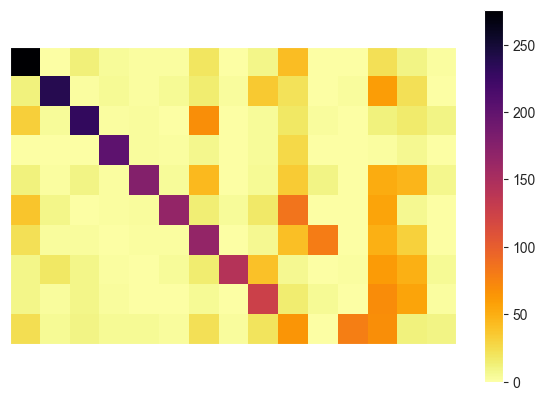

In [69]:
#plot conf matrices
algo_to_plot =2
matrix_to_show = np.transpose(np.transpose(conf_matrices[algo_to_plot])[:40])
plt.matshow(matrix_to_show,cmap='inferno_r')
plt.gca().grid(False)
#white background
plt.gca().set_facecolor('white')
plt.xticks([])
plt.yticks([])
plt.colorbar()

plt.tight_layout()
plt.savefig(f"se_plots/{dataset_diff}_{cluster_algos[algo_to_plot].__name__}.png",dpi=300,bbox_inches='tight')
plt.show()

In [51]:
dataset_diff = dataset_diffs[2]
pair_conf_matrices = []
for cluster_algo in cluster_algos:
        cluster_labels, true_labels = laod_clustering_noise_cleaned(dataset_diff,cluster_algo)
        pair_conf_matrix = get_pair_confusion_matrix(true_labels,cluster_labels)
        pair_conf_matrices.append(pair_conf_matrix)

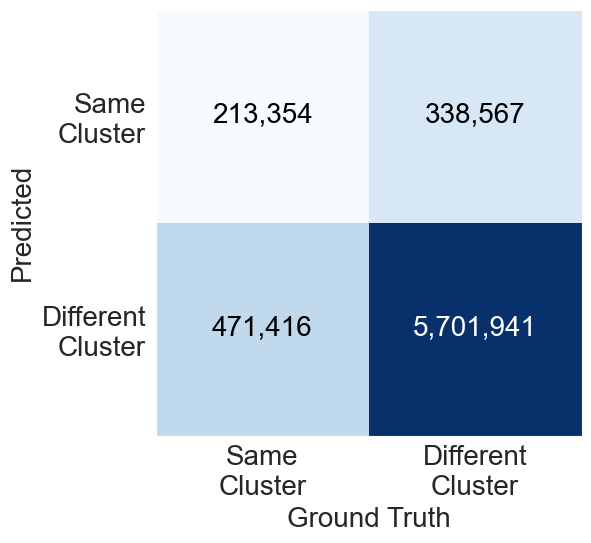

In [72]:
algo_to_plot = 2
matrix_to_show = pair_conf_matrices[algo_to_plot]
log_matrix = np.log(np.log(matrix_to_show))
class_labels_true = ['Same\nCluster', 'Different\nCluster']
class_labels_pred = ['Same\nCluster', 'Different\nCluster']


# Create the plot
plt.figure(figsize=(6, 6))
plt.imshow(log_matrix, interpolation='nearest', cmap=plt.cm.Blues)

# Add title and labels
plt.xlabel("Ground Truth",fontsize=20)
plt.ylabel("Predicted",fontsize=20)

# Add ticks and labels for the axes
tick_marks = np.arange(2)
plt.xticks(tick_marks, class_labels_true)
plt.yticks(tick_marks, class_labels_pred)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.gca().grid(False)
# Add annotations (numbers in the matrix cells)
thresh = matrix_to_show.max() / 2.
for i, j in np.ndindex(matrix_to_show.shape):
    plt.text(j, i, format(int(matrix_to_show[i, j]), ',d'),
             ha="center", va="center",fontsize=20,
             color="white" if matrix_to_show[i, j] > thresh else "black")

# Add a colorbar (optional)
#plt.colorbar()

# Show the plot
plt.tight_layout()
plt.savefig(f"se_plots/pair_{dataset_diff}_{cluster_algos[algo_to_plot].__name__}.png",dpi=300, bbox_inches='tight')
plt.show()

In [80]:
table_columns = [xmeans_clustering,hdbscan_clustering,agglomerative_clustering_with_estimated_k]
table_rows = dataset_diffs

Acc_table = np.zeros((len(table_columns), len(table_rows)))
Rec_table = np.zeros((len(table_columns), len(table_rows)))
F1_table = np.zeros((len(table_columns), len(table_rows)))
Phi_table = np.zeros((len(table_columns), len(table_rows)))


for i, algorithm in enumerate(cluster_algos):
    for j, dataset_diff in enumerate(dataset_diffs):
        cluster_labels, true_labels = laod_clustering_noise_cleaned(dataset_diff,algorithm)
        pair_conf_matrix = get_pair_confusion_matrix(true_labels,cluster_labels)

        acc = pair_conf_matrix[0,0]/(pair_conf_matrix[0,0]+pair_conf_matrix[0,1])
        rec = pair_conf_matrix[0,0]/(pair_conf_matrix[0,0]+pair_conf_matrix[1,0])
        f1 = (2*pair_conf_matrix[0,0])/(2*pair_conf_matrix[0,0]+pair_conf_matrix[1,0]+pair_conf_matrix[0,1])
        phi = (pair_conf_matrix[0,0]*pair_conf_matrix[1,1]-pair_conf_matrix[0,1]*pair_conf_matrix[1,0])/math.sqrt((pair_conf_matrix[0,0]+pair_conf_matrix[0,1])*(pair_conf_matrix[1,0]+pair_conf_matrix[1,1])*(pair_conf_matrix[0,0]+pair_conf_matrix[1,0])*(pair_conf_matrix[0,1]+pair_conf_matrix[1,1]))

        Acc_table[i,j] = acc
        Rec_table[i,j] = rec
        F1_table[i,j] = f1
        Phi_table[i,j] = phi

In [82]:
for i,table_row in enumerate(table_rows):
    print(f"""
\multirow{{4}}{{*}}{{\\textbf{{{table_row}}}}} & accuracy & {' & '.join([f'{val:.2f}' for val in Acc_table[:,i]])} \\\\
        & recall &  {' & '.join([f'{val:.2f}' for val in Rec_table[:,i]])}\\\\
        & f1 &  {' & '.join([f'{val:.2f}' for val in F1_table[:,i]])} \\\\
        & $\\phi$ &  {' & '.join([f'{val:.2f}' for val in Phi_table[:,i]])} \\\\
        \hline""")


\multirow{4}{*}{\textbf{easy}} & accuracy & 0.69 & 0.92 & 0.61 \\
        & recall &  0.47 & 0.10 & 0.52\\
        & f1 &  0.56 & 0.18 & 0.56 \\
        & $\phi$ &  0.53 & 0.28 & 0.52 \\
        \hline

\multirow{4}{*}{\textbf{medium}} & accuracy & 0.63 & 0.85 & 0.56 \\
        & recall &  0.51 & 0.08 & 0.45\\
        & f1 &  0.57 & 0.14 & 0.50 \\
        & $\phi$ &  0.53 & 0.24 & 0.45 \\
        \hline

\multirow{4}{*}{\textbf{hard}} & accuracy & 0.48 & 0.81 & 0.39 \\
        & recall &  0.42 & 0.09 & 0.31\\
        & f1 &  0.45 & 0.16 & 0.35 \\
        & $\phi$ &  0.39 & 0.25 & 0.28 \\
        \hline


In [57]:
#AMI
from sklearn.metrics import adjusted_mutual_info_score
table_columns = [xmeans_clustering, hdbscan_clustering, agglomerative_clustering_with_estimated_k]
table_rows = dataset_diffs

AMI_table = np.zeros((len(table_columns), len(table_rows)))

for i, algorithm in enumerate(cluster_algos):
    for j, dataset_diff in enumerate(dataset_diffs):
        cluster_labels, true_labels = laod_clustering_noise_cleaned(dataset_diff, algorithm)
        ami = adjusted_mutual_info_score(true_labels, cluster_labels)
        AMI_table[i,j] = ami

In [61]:
for i,table_row in enumerate(table_rows):
    print(f"\\textbf{{{table_row}}} & {' & '.join([f'{val:.2f}' for val in AMI_table[:,i]])} \\\\\\hline")

\textbf{easy} & 0.64 & 0.53 & 0.59 \\\hline
\textbf{medium} & 0.61 & 0.49 & 0.54 \\\hline
\textbf{hard} & 0.48 & 0.45 & 0.39 \\\hline


In [64]:
from sklearn.metrics import silhouette_score,davies_bouldin_score,calinski_harabasz_score
table_columns = [xmeans_clustering, hdbscan_clustering, agglomerative_clustering_with_estimated_k]
table_rows = dataset_diffs

S_table = np.zeros((len(table_columns), len(table_rows)))
DB_table = np.zeros((len(table_columns), len(table_rows)))
CH_table = np.zeros((len(table_columns), len(table_rows)))

for i, algorithm in enumerate(cluster_algos):
    for j, dataset_diff in enumerate(dataset_diffs):
        cluster_labels, embedding = laod_clustering_noise_cleaned_embedding(dataset_diff, algorithm)

        s = silhouette_score(embedding, cluster_labels)
        db = davies_bouldin_score(embedding, cluster_labels)
        ch = calinski_harabasz_score(embedding, cluster_labels)

        S_table[i, j] = s
        DB_table[i, j] = db
        CH_table[i, j] = ch
for i, table_row in enumerate(table_rows):
    print(f"""
\multirow{{3}}{{*}}{{\\textbf{{{table_row}}}}} & S & {' & '.join([f'{val:.2f}' for val in S_table[:, i]])} \\\\
        & DB &  {' & '.join([f'{val:.2f}' for val in DB_table[:, i]])}\\\\
        & CH &  {' & '.join([f'{val:.2f}' for val in CH_table[:, i]])} \\\\
        \hline""")


\multirow{3}{*}{\textbf{easy}} & S & 0.04 & 0.11 & 0.05 \\
        & DB &  3.78 & 2.26 & 3.81\\
        & CH &  70.62 & 10.64 & 69.93 \\
        \hline

\multirow{3}{*}{\textbf{medium}} & S & 0.08 & 0.16 & 0.07 \\
        & DB &  3.27 & 2.27 & 3.58\\
        & CH &  80.74 & 11.63 & 72.00 \\
        \hline

\multirow{3}{*}{\textbf{hard}} & S & 0.04 & 0.08 & 0.03 \\
        & DB &  3.59 & 2.35 & 4.32\\
        & CH &  65.07 & 8.74 & 49.79 \\
        \hline
